In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import kornia
import numpy as np
import theseus as th
import matplotlib.pyplot as plt
import utils
from utils import ImagePair, ImageMatcher
import h5py

In [3]:
DATA_DIR = '/Users/richard/Desktop/Dataset/'
trajs = np.load(DATA_DIR + '000.npy')
frames = utils.load_video(DATA_DIR + 's-000.mp4', grayscale=True)
matcher = ImageMatcher()

Matched points: 438
[160.7424055   -3.63613531  -2.43414416  75.        ]
[161.06837406  -3.65335207  -2.35256079  75.        ]


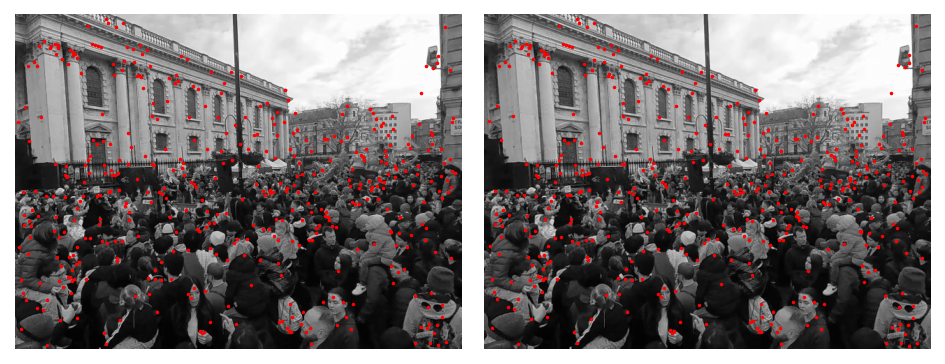

In [4]:
i, j = 0, 1
p = matcher.match(frames[i], frames[j], i, j)

if p is not None:
    print(f'Matched points: {len(p.src_pts)}')
    utils.export_image_pair(DATA_DIR + f'p{i}-{j}.h5', p)
else:
    print('No match.')


print(trajs[i])
print(trajs[j])

utils.visualize_matches(p)

In [134]:
print(p.H)

[[ 8.48698645e-01  1.35265087e-02  6.94478705e+01]
 [-5.11591222e-02  9.55551652e-01 -7.50125777e-01]
 [-2.63173825e-04  6.94317091e-05  1.00000000e+00]]


In [127]:
logR0 = th.Vector(3, name='log_R0')
f0 = th.Vector(tensor=torch.tensor([[640]]).float(), name='f0')
logR1 = th.Vector(3, name='log_R1')
f1 = th.Vector(tensor=torch.tensor([[640]]).float(), name='f1')

src_pts = th.Variable(
    torch.tensor(p.src_pts).unsqueeze(0),
    name='src_pts',
)

dst_pts = th.Variable(
    torch.tensor(p.dst_pts).unsqueeze(0),
    name='dst_pts',
)

In [128]:
def reprojection_error(M_batch: torch.Tensor, src_pts_batch, dst_pts_batch,
                       graph=False):
    ones = torch.ones([*src_pts_batch.shape[:2], 1])
    pts_h = torch.cat([src_pts_batch, ones], axis=2)
    proj_pts_h = pts_h @ M_batch.transpose(1, 2)
    proj_pts = proj_pts_h[:, :, :2] / proj_pts_h[:, :, 2:3]
    r = torch.sqrt(torch.square(proj_pts - dst_pts_batch).sum(axis=2))
    return r
    if graph:
        for i in range(src_pts_batch.shape[0]):
            fig, ax = plt.subplots(figsize=(6, 4.5), dpi=50)
            ax.set_title(f'Pair {i}')
            ax.scatter(dst_pts_batch[i,:,0].detach().numpy(),
                        dst_pts_batch[i,:,1].detach().numpy(),
                        marker='+', c='g')
            ax.scatter(proj_pts[i,:,0].detach().numpy(),
                        proj_pts[i,:,1].detach().numpy(),
                        marker='x', c='r', linewidths=0.5)
            fig.tight_layout()
            plt.show()
            plt.close()
    print(r.shape)
    err = torch.sqrt(r).mean(axis=1)
    print(err.shape)
    return err


def im(f0):
    batch_size = f0.shape[0]

    # Create the elements of the intrinsic matrix K
    K00 = -f0[:, 0].unsqueeze(1).unsqueeze(1)
    K01 = torch.zeros((batch_size, 1, 1), device=f0.device, dtype=f0.dtype)
    K02 = torch.full((batch_size, 1, 1), 320, device=f0.device, dtype=f0.dtype)

    K10 = torch.zeros((batch_size, 1, 1), device=f0.device, dtype=f0.dtype)
    K11 = f0[:, 0].unsqueeze(1).unsqueeze(1)
    K12 = torch.full((batch_size, 1, 1), 240, device=f0.device, dtype=f0.dtype)

    K20 = torch.zeros((batch_size, 1, 1), device=f0.device, dtype=f0.dtype)
    K21 = torch.zeros((batch_size, 1, 1), device=f0.device, dtype=f0.dtype)
    K22 = torch.ones((batch_size, 1, 1), device=f0.device, dtype=f0.dtype)

    # Stack the elements to form the 3x3 intrinsic matrix
    K = torch.cat([torch.cat([K00, K01, K02], dim=2),
                torch.cat([K10, K11, K12], dim=2),
                torch.cat([K20, K21, K22], dim=2)], dim=1)
    return K


def error_fn(optim_vars: list[th.Variable],
             aux_vars: list[th.Variable]):
    logR0, f0, logR1, f1 = [v.tensor for v in optim_vars]
    src_pts, dst_pts = [v.tensor for v in aux_vars]
    R0 = kornia.geometry.axis_angle_to_rotation_matrix(logR0)
    K0 = im(f0)

    R1 = kornia.geometry.axis_angle_to_rotation_matrix(logR1)
    K1 = im(f1)

    H = K1 @ R1 @ R0.inverse() @ K0.inverse()
    e = reprojection_error(H, src_pts, dst_pts)
    return e



In [129]:
cost = th.AutoDiffCostFunction(
    optim_vars=(logR0, f0, logR1, f1),
    err_fn=error_fn,
    dim=297,
    aux_vars=(src_pts, dst_pts),
)

obj = th.Objective()
obj.add(cost)

opt = th.GaussNewton(
    obj, max_iterations=500, step_size=0.01,
)

th_opt = th.TheseusLayer(opt)

In [130]:
with torch.no_grad():
    updated_inputs, info = th_opt.forward(
        None, optimizer_kwargs={"track_best_solution": True, "verbose": True})

print("Best solution:", info.best_solution)


Nonlinear optimizer. Iteration: 0. Error: 501820.0
Best solution: {'log_R0': tensor([[0., 0., 0.]]), 'f0': tensor([[640.]]), 'log_R1': tensor([[0., 0., 0.]]), 'f1': tensor([[640.]])}


/usr/local/Caskroom/miniforge/base/lib/python3.10/site-packages/theseus/optimizer/nonlinear/nonlinear_least_squares.py:150: RuntimeWarning: There was an error while running the linear optimizer. Original error message: linalg.cholesky: (Batch element 0): The factorization could not be completed because the input is not positive-definite (the leading minor of order 1 is not positive-definite)..
  warnings.warn(msg, RuntimeWarning)


In [126]:
utils.reprojection_error(np.eye(3, 3), p.src_pts, p.dst_pts)

57.73181043219014

In [139]:

f = 5
a = 320
b = 240

i = np.array([
    [-f, 0, a],
    [ 0, f, b],
    [ 0, 0, 1]
])

j = np.array([
    [-1/f, 0, a/f],
    [ 0, 1/f, -b/f],
    [ 0, 0, 1]
])

print(i @ j)
print(j @ i)


[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
